Importing Libraries

In [24]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Restart the kernel after installing the packages
!pip install --upgrade numpy
!pip install --upgrade tensorflow
import tensorflow as tf # Import tensorflow after upgrading it
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is in

Importing Dataset

In [25]:
# Install required libraries if not already present
!pip install xgboost lightgbm scikit-learn pandas numpy tensorflow

# Import necessary library
import pandas as pd

# Load dataset directly from Colab's /content directory
dataset_path = ('/content/diabetes_prediction_dataset.csv')
dataset = pd.read_csv(dataset_path)

# Display first few rows
print("Dataset Preview:")
print(dataset.head())

Dataset Preview:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


Data Processing

In [26]:
# Encode categorical variables
le_gender = LabelEncoder()
le_smoking = LabelEncoder()
dataset['gender'] = le_gender.fit_transform(dataset['gender'])
dataset['smoking_history'] = le_smoking.fit_transform(dataset['smoking_history'])

# Separate features and target
X = dataset.drop('diabetes', axis=1)
y = dataset['diabetes']

print("Data preprocessed with encoded categorical variables.")

Data preprocessed with encoded categorical variables.


Feature Extraction

In [27]:
# Feature Extraction
def extract_features(df):
    # 1. BMI Category
    bins_bmi = [0, 18.5, 25, 30, float('inf')]
    labels_bmi = [0, 1, 2, 3]  # 0: Underweight, 1: Normal, 2: Overweight, 3: Obese
    df['bmi_category'] = pd.cut(df['bmi'], bins=bins_bmi, labels=labels_bmi, right=False)

    # 2. Age Group
    bins_age = [0, 30, 50, 70, float('inf')]
    labels_age = [0, 1, 2, 3]  # 0: Young, 1: Middle-aged, 2: Senior, 3: Elderly
    df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, right=False)

    # 3. Risk Score (sum of binary risk factors)
    df['risk_score'] = df['hypertension'] + df['heart_disease'] + (df['smoking_history'] > 0).astype(int)

    # 4. Glucose-HbA1c Interaction
    df['glucose_hba1c_interaction'] = df['blood_glucose_level'] * df['HbA1c_level']

    # 5. Health Index
    df['health_index'] = df['bmi'] / (df['age'] + 1)  # +1 to avoid division by zero

    return df

# Apply feature extraction
dataset = extract_features(dataset)

# Update X with new features
X = dataset.drop('diabetes', axis=1)
print("New features extracted:")
print(X.head())

New features extracted:
   gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       0  80.0             0              1                4  25.19   
1       0  54.0             0              0                0  27.32   
2       1  28.0             0              0                4  27.32   
3       0  36.0             0              0                1  23.45   
4       1  76.0             1              1                1  20.14   

   HbA1c_level  blood_glucose_level bmi_category age_group  risk_score  \
0          6.6                  140            2         3           2   
1          6.6                   80            2         2           0   
2          5.7                  158            2         0           1   
3          5.0                  155            1         1           1   
4          4.8                  155            1         3           3   

   glucose_hba1c_interaction  health_index  
0                      924.0      0.310988  
1       

Data Cleaning

In [28]:
# Check for missing values
print("Missing Values:\n", dataset.isnull().sum())

# No missing values in your dataset, but if there were, we could handle them like this:
# dataset.fillna(dataset.mean(), inplace=True)  # Example for numerical columns

# Check for duplicates
print("Duplicate Rows:", dataset.duplicated().sum())
dataset = dataset.drop_duplicates()  # Remove duplicates if any

# Re-separate after cleaning
X = dataset.drop('diabetes', axis=1)
y = dataset['diabetes']

print("Data cleaned.")

Missing Values:
 gender                       0
age                          0
hypertension                 0
heart_disease                0
smoking_history              0
bmi                          0
HbA1c_level                  0
blood_glucose_level          0
diabetes                     0
bmi_category                 0
age_group                    0
risk_score                   0
glucose_hba1c_interaction    0
health_index                 0
dtype: int64
Duplicate Rows: 3854
Data cleaned.


Data Visualization

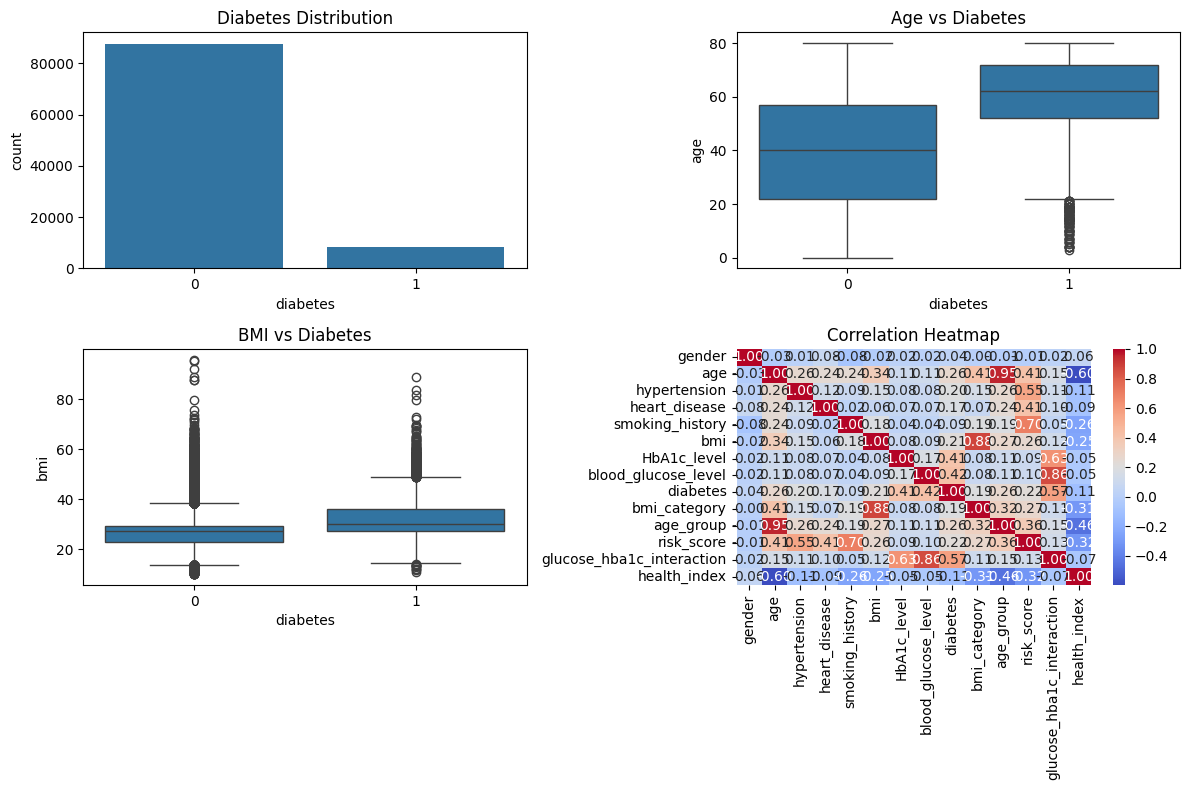

In [29]:
# Visualizations
plt.figure(figsize=(12, 8))

# 1. Distribution of Diabetes
plt.subplot(2, 2, 1)
sns.countplot(x='diabetes', data=dataset)
plt.title('Diabetes Distribution')

# 2. Age vs Diabetes
plt.subplot(2, 2, 2)
sns.boxplot(x='diabetes', y='age', data=dataset)
plt.title('Age vs Diabetes')

# 3. BMI vs Diabetes
plt.subplot(2, 2, 3)
sns.boxplot(x='diabetes', y='bmi', data=dataset)
plt.title('BMI vs Diabetes')

# 4. Correlation Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

Training And Testing

In [30]:
# Split into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2 of total

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (57687, 13), Validation set: (19229, 13), Test set: (19230, 13)


Model Training And Comparision

In [31]:
# Dictionary to store metrics
metrics = {'Model': [], 'Accuracy': [], 'F1-Score': [], 'AUC-ROC': []}

# Function to evaluate model
def evaluate_model(model, X_test, y_test, model_name, is_lstm=False, lstm_prob=None):
    if is_lstm:
        y_pred = np.argmax(model.predict(X_test), axis=1)  # LSTM predictions are multi-output
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, lstm_prob)  # Use probability for AUC-ROC
    else:
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, 'predict_proba') else roc_auc_score(y_test, y_pred)

    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(acc)
    metrics['F1-Score'].append(f1)
    metrics['AUC-ROC'].append(auc)
    print(f"{model_name} - Accuracy: {acc:.4f}, F1-Score: {f1:.4f}, AUC-ROC: {auc:.4f}")

# 1. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
evaluate_model(rf, X_test_scaled, y_test, 'Random Forest')

# 2. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)
evaluate_model(xgb, X_test_scaled, y_test, 'XGBoost')

# 3. SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
evaluate_model(svm, X_test_scaled, y_test, 'SVM')

# 4. Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
evaluate_model(lr, X_test_scaled, y_test, 'Logistic Regression')

# 5. LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train_scaled, y_train)
evaluate_model(lgbm, X_test_scaled, y_test, 'LightGBM')

# 6. Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)
evaluate_model(gb, X_test_scaled, y_test, 'Gradient Boosting')

# 7. Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
evaluate_model(qda, X_test_scaled, y_test, 'QDA')

# 8. LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, X_train_scaled.shape[1]), return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(2, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_cat, epochs=10, batch_size=32, verbose=0)
lstm_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
lstm_prob = lstm_model.predict(X_test_lstm)[:, 1]  # Probability for class 1
evaluate_model(lstm_model, X_test_lstm, y_test, 'LSTM', is_lstm=True, lstm_prob=lstm_prob)

# Display comparison
metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
print(metrics_df)

Random Forest - Accuracy: 0.9686, F1-Score: 0.7972, AUC-ROC: 0.9629
XGBoost - Accuracy: 0.9693, F1-Score: 0.8019, AUC-ROC: 0.9761
SVM - Accuracy: 0.9613, F1-Score: 0.7298, AUC-ROC: 0.9127
Logistic Regression - Accuracy: 0.9581, F1-Score: 0.7297, AUC-ROC: 0.9621
[LightGBM] [Info] Number of positive: 5072, number of negative: 52615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087923 -> initscore=-2.339266
[LightGBM] [Info] Start training from score -2.339266
LightGBM - Accuracy: 0.9700, F1-Score: 0.8033, AUC-ROC: 0.9771
Gradient Boosting - Accuracy: 0.9708, F1-Score: 0.8070, AUC-ROC: 0.9785
QDA - Accuracy: 0.8841, F1-Score: 0.5370, AUC-R

Validation Set Evaluation

In [34]:
# Evaluate models on validation set
print("\nValidation Set Performance:")
for model, name in [(rf, 'Random Forest'), (xgb, 'XGBoost'), (svm, 'SVM'), (lr, 'Logistic Regression'),
                    (lgbm, 'LightGBM'), (gb, 'Gradient Boosting'), (qda, 'QDA')]:
    y_val_pred = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")

# LSTM Validation
X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
y_val_cat = to_categorical(y_val)
lstm_val_pred = np.argmax(lstm_model.predict(X_val_lstm), axis=1)
print(f"LSTM Validation Accuracy: {accuracy_score(y_val, lstm_val_pred):.4f}")


Validation Set Performance:
Random Forest Validation Accuracy: 0.9686
XGBoost Validation Accuracy: 0.9683
SVM Validation Accuracy: 0.9613
Logistic Regression Validation Accuracy: 0.9590
LightGBM Validation Accuracy: 0.9693
Gradient Boosting Validation Accuracy: 0.9703
QDA Validation Accuracy: 0.8842
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step
LSTM Validation Accuracy: 0.9652


Optimizer Graph

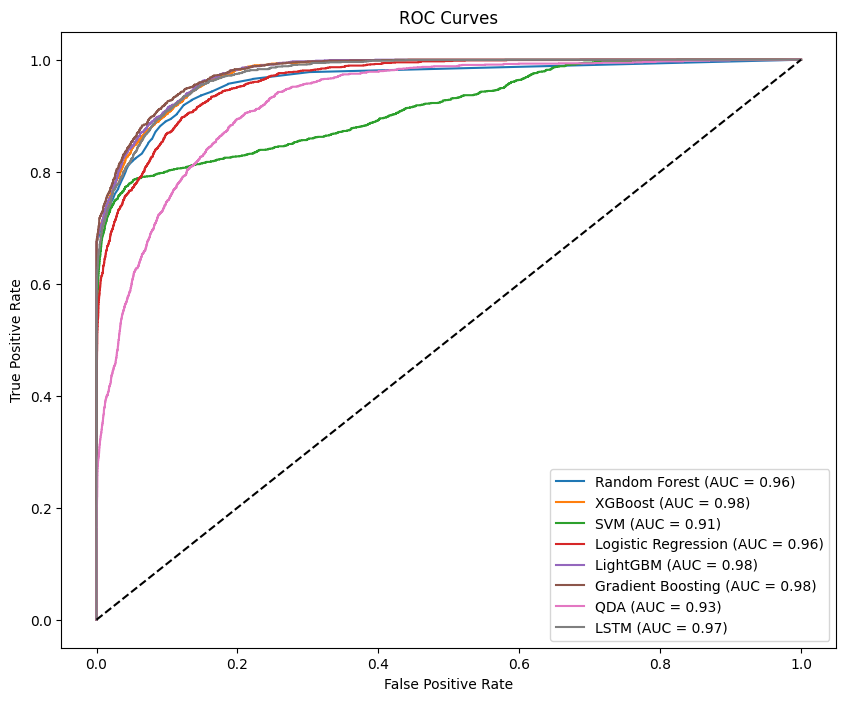

In [35]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for model, name in [(rf, 'Random Forest'), (xgb, 'XGBoost'), (svm, 'SVM'), (lr, 'Logistic Regression'),
                    (lgbm, 'LightGBM'), (gb, 'Gradient Boosting'), (qda, 'QDA')]:
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")

# LSTM ROC
fpr, tpr, _ = roc_curve(y_test, lstm_prob)
plt.plot(fpr, tpr, label=f"LSTM (AUC = {roc_auc_score(y_test, lstm_prob):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

Prediction Model

In [38]:
# Save the Gradient Boosting model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(gb, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('le_gender.pkl', 'wb') as f:
    pickle.dump(le_gender, f)
with open('le_smoking.pkl', 'wb') as f:
    pickle.dump(le_smoking, f)

# Prediction function with health recommendations and nearest doctor
def predict_diabetes():
    # Collect user input
    gender = input("Enter gender (Male/Female): ")
    age = float(input("Enter age: "))
    hypertension = int(input("Hypertension (0 for No, 1 for Yes): "))
    heart_disease = int(input("Heart disease (0 for No, 1 for Yes): "))
    smoking_history = input("Smoking history (never, former, current, not current, ever, No Info): ")
    bmi = float(input("Enter BMI: "))
    hba1c = float(input("Enter HbA1c level: "))
    blood_glucose = float(input("Enter blood glucose level: "))

    # Create user data with original features in the same order as training
    user_data = pd.DataFrame({
        'gender': [le_gender.transform([gender])[0]],
        'age': [age],
        'hypertension': [hypertension],
        'heart_disease': [heart_disease],
        'smoking_history': [le_smoking.transform([smoking_history])[0]],
        'bmi': [bmi],
        'HbA1c_level': [hba1c],
        'blood_glucose_level': [blood_glucose]
    })

    # Apply feature extraction to match training data
    user_data = extract_features(user_data)

    # Ensure column order matches training data
    training_columns = X.columns  # From Cell 3.5
    user_data = user_data[training_columns]

    # Scale and predict using Gradient Boosting
    user_data_scaled = scaler.transform(user_data)
    prediction = gb.predict(user_data_scaled)[0]
    probability = gb.predict_proba(user_data_scaled)[0][1] * 100
    diabetes_type = "Type 2" if age > 30 else "Type 1 (or possibly Type 2)" if prediction == 1 else "None"

    # Health recommendations based on prediction and inputs
    print("\n=== Health Recommendations ===")
    if prediction == 1:
        print("Diabetes predicted. Consider the following:")
        if bmi >= 25:
            print("- Weight Management: Your BMI is high (%.1f). Aim for a balanced diet and regular exercise to reduce it to a healthy range (18.5-24.9)." % bmi)
        if hba1c > 6.5:
            print("- Blood Sugar Control: Your HbA1c (%.1f) is elevated. Monitor it regularly and consult a doctor about medication or insulin." % hba1c)
        if blood_glucose > 126:
            print("- Glucose Monitoring: Your blood glucose (%.1f) is high. Check it daily and avoid sugary foods." % blood_glucose)
        if smoking_history.lower() != "never":
            print("- Quit Smoking: Smoking increases diabetes complications. Seek support to quit.")
    else:
        print("No diabetes predicted. Maintain your health with:")
        print("- Healthy Diet: Continue eating balanced meals low in sugar and saturated fats.")
        print("- Exercise: Aim for at least 150 minutes of moderate activity per week.")
        if bmi >= 25:
            print("- Watch Your Weight: Your BMI (%.1f) is above normal. Consider gradual weight loss to stay healthy." % bmi)

    # Prediction output
    print(f"\nPrediction: {'Diabetes' if prediction == 1 else 'No Diabetes'}")
    print(f"Risk Probability: {probability:.2f}%")
    print(f"Predicted Diabetes Type: {diabetes_type}")

# Test the prediction
predict_diabetes()

Enter gender (Male/Female): Male
Enter age: 80
Hypertension (0 for No, 1 for Yes): 1
Heart disease (0 for No, 1 for Yes): 1
Smoking history (never, former, current, not current, ever, No Info): former
Enter BMI: 28
Enter HbA1c level: 8
Enter blood glucose level: 150

=== Health Recommendations ===
Diabetes predicted. Consider the following:
- Weight Management: Your BMI is high (28.0). Aim for a balanced diet and regular exercise to reduce it to a healthy range (18.5-24.9).
- Blood Sugar Control: Your HbA1c (8.0) is elevated. Monitor it regularly and consult a doctor about medication or insulin.
- Glucose Monitoring: Your blood glucose (150.0) is high. Check it daily and avoid sugary foods.
- Quit Smoking: Smoking increases diabetes complications. Seek support to quit.

Prediction: Diabetes
Risk Probability: 99.23%
Predicted Diabetes Type: Type 2
